In [1]:
#https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

In [2]:
# importing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
from tensorflow.python.keras import backend as k
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import models as keras_model
from tensorflow.keras.preprocessing import image
from time import time
import tensorflow as tf
import datetime
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from PIL import Image
sourceSize = 'center_crop_clean_300'
img_width, img_height = 300, 300


train_data_dir = '3_Classes/data_3C_from_'+sourceSize+'_to_'+str(img_width)+'/train'
validation_data_dir = '3_Classes/data_3C_from_'+sourceSize+'_to_'+str(img_width)+'/val'
test_data_dir = '3_Classes/data_3C_from_'+sourceSize+'_to_'+str(img_width)+'/test'
nb_train_samples = 10000
nb_validation_samples = 2700
epochs = 10
batch_size = 4

if k.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')


top_model_dir = 'models\\'
top_model_allFiles = glob.glob('models\\*h5')
TopModel_preformanceList = []

Found 333 images belonging to 3 classes.


In [5]:
top_model_allFiles

['models\\BestModel300_320_001_20200228-085750.h5']

In [6]:
eachModel = top_model_allFiles[0]
modelName =  (eachModel.split('\\')[-1][:-20])
#TopModel_list.append(file_.split('\\')[-1][:-20])

modelPath = eachModel
model = load_model(modelPath)
print(model.summary())
score = model.evaluate_generator(test_generator, verbose=1)
print(score)

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
print('Classification Report')
target_names = ['bacteria','normal','virus']
cr = classification_report(test_generator.classes, y_pred, target_names=target_names)
print(cr)
print(score)
TopModel_preformanceList.append((modelName,cm,cr,score))

print (TopModel_preformanceList)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 69, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)      

## Bacteria Image

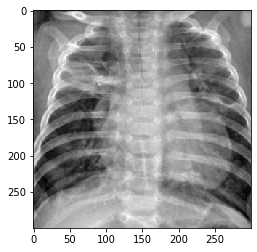

(1, 300, 300, 3)
Predicted class is: [0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


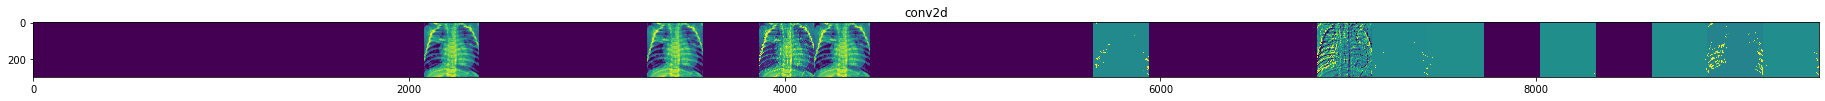

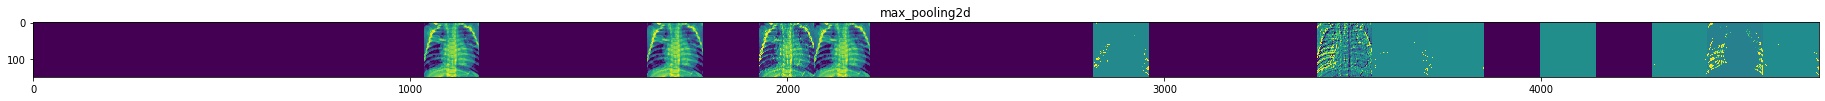

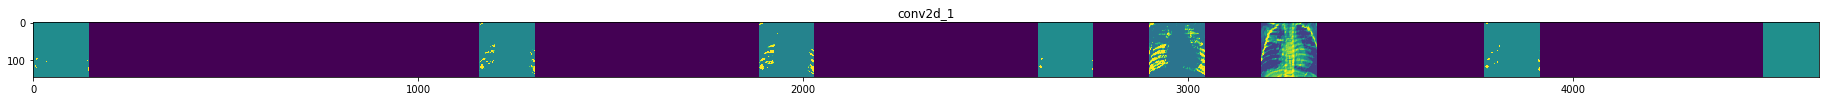

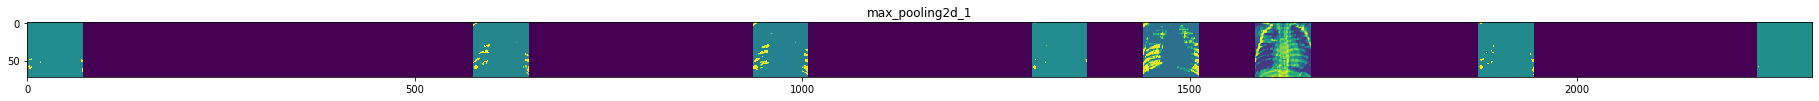

In [33]:
#Predicting new image
img_path = '3_Classes\\data_3C_from_center_crop_clean_300_to_300\\test\\bacteria\\person630_bacteria_2512.jpeg'

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

classes = model.predict_classes(img_tensor)
print("Predicted class is:",classes)

# Extracts the outputs of the top 4 layers
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input
activation_model = keras_model.Model(inputs=model.input, outputs=layer_outputs) 

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

layer_names = []
#model.summary()
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 32

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Normal Images

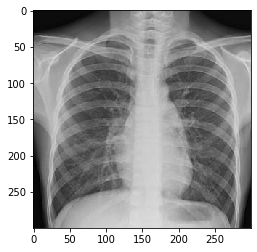

(1, 300, 300, 3)
Predicted class is: [1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


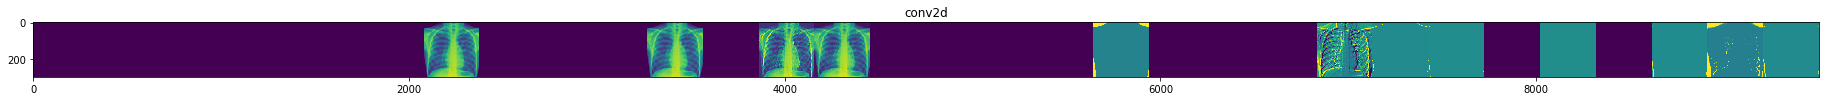

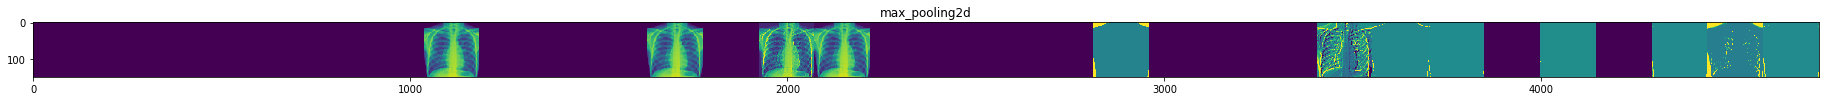

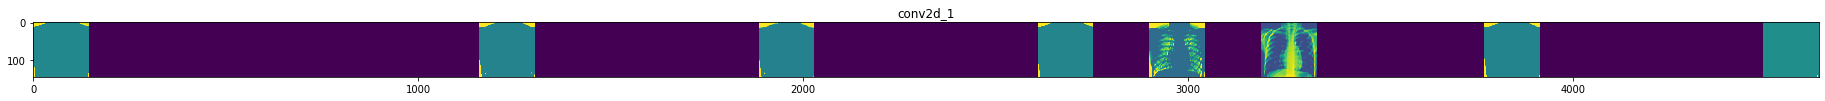

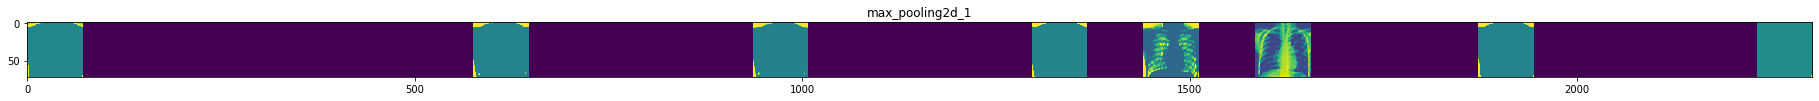

In [32]:
#Predicting new image
img_path = '3_Classes\\data_3C_from_center_crop_clean_300_to_300\\test\\normal\\NORMAL2-IM-0059-0001.jpeg'

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

classes = model.predict_classes(img_tensor)
print("Predicted class is:",classes)

# Extracts the outputs of the top 4 layers
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input
activation_model = keras_model.Model(inputs=model.input, outputs=layer_outputs) 

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

layer_names = []
#model.summary()
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 32

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Virus

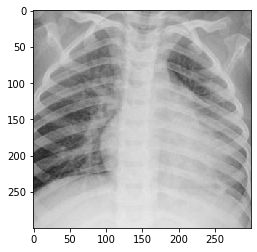

(1, 300, 300, 3)
Prediction Time:  0:00:00.049011
Predicted class is: [2]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


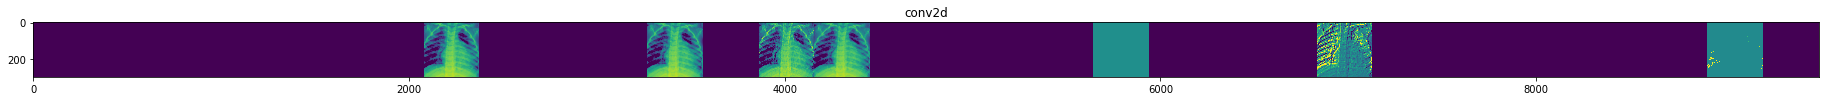

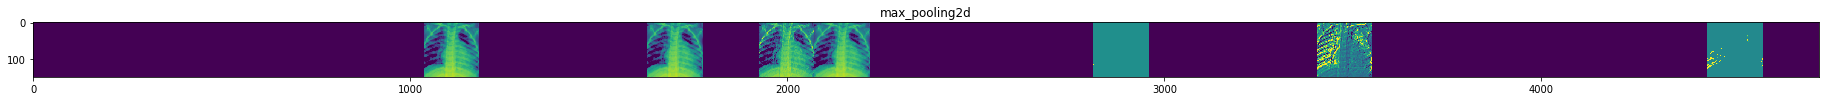

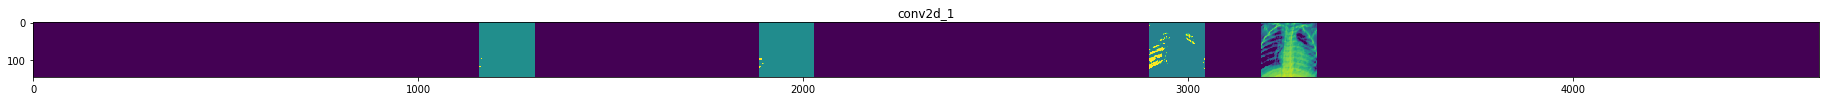

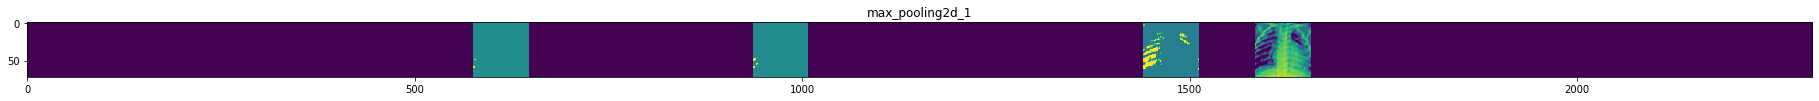

In [31]:
#Predicting new image
from datetime import datetime
img_path = '3_Classes\\data_3C_from_center_crop_clean_300_to_300\\test\\virus\\person610_virus_1177.jpeg'

img = image.load_img(img_path, target_size=(img_width, img_height))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

startTimer = datetime.now()
classes = model.predict_classes(img_tensor)
elapstedTime = datetime.now() - startTimer
print ('Prediction Time: ',elapstedTime)
print("Predicted class is:",classes)

# Extracts the outputs of the top 4 layers
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input
activation_model = keras_model.Model(inputs=model.input, outputs=layer_outputs) 

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

layer_names = []
#model.summary()
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 32

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 69, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)      